In [18]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow import keras

In [19]:
# Định nghĩa đường dẫn dataset
dataset_path = "/kaggle/input/btxrd-data/BTXRD/BTXRD/"
image_dir = os.path.join(dataset_path, "images")
json_dir = os.path.join(dataset_path, "Annotations")

# Tạo DataFrame từ file JSON
image_files = []
labels = []

for json_file in os.listdir(json_dir):
    if json_file.endswith(".json"):
        with open(os.path.join(json_dir, json_file), "r") as f:
            data = json.load(f)
            image_filename = data["imagePath"]
            label = data["shapes"][0]["label"] if data["shapes"] else "unknown"
            
            image_path = os.path.join(image_dir, image_filename)
            if os.path.exists(image_path):
                image_files.append(image_path)
                labels.append(label)

# Tạo DataFrame
df = pd.DataFrame({"filename": image_files, "class": labels})

# Thiết lập ImageDataGenerator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df, 
    x_col="filename", 
    y_col="class", 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    df, 
    x_col="filename", 
    y_col="class", 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(train_generator.samples, 'train samples')
print(val_generator.samples, 'validation samples')

Found 1494 validated image filenames belonging to 9 classes.
Found 373 validated image filenames belonging to 9 classes.
1494 train samples
373 validation samples


In [20]:
# Lấy số lớp từ dữ liệu
num_classes = len(train_generator.class_indices)

# Định nghĩa mô hình
input_image = Input(shape=(224, 224, 3), name='Input')
x = Flatten(name='flatten')(input_image)
x = Dense(units=512, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2, name='dropout1')(x)
x = Dense(units=512, activation='relu', name='fc2')(x)
x = Dropout(rate=0.2, name='dropout2')(x)
output_label = Dense(units=num_classes, activation='softmax', name='fc3_softmax')(x)

model = Model(inputs=input_image, outputs=output_label, name='btxrd_xray_mlp')
model.summary()

Model: "btxrd_xray_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3_softmax (Dense)                  │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,338,121 (295.02 MB)

 Trainable params: 77,338,121 (295.02 MB)

 Non-trainable params: 0 (0.00 B)

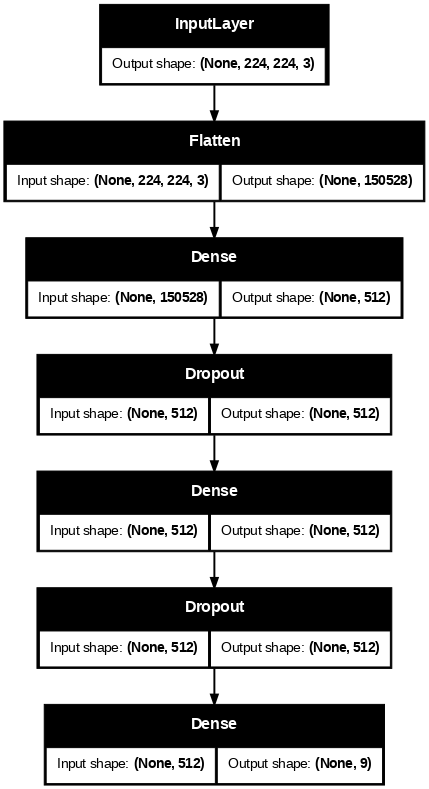

In [23]:
# Hiển thị mô hình
from IPython.display import display
from tensorflow.keras.utils import plot_model

# Lưu mô hình dưới dạng file hình ảnh rồi hiển thị
plot_model(model, show_shapes=True, dpi=70, to_file="model_structure.png")

# Hiển thị hình ảnh mô hình
from PIL import Image
img = Image.open("model_structure.png")
display(img)


In [ ]:
# Cấu hình huấn luyện
loss = 'categorical_crossentropy'
lr = 0.01
model.compile(loss=loss, optimizer=SGD(learning_rate=lr), metrics=['accuracy'])

# Huấn luyện mô hình
batch_size = 32
epochs = 30

starting_time = time.time()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size
)
print('> Training time is %.4f minutes' % ((time.time() - starting_time)/60))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2900 - loss: 3.0259 - val_accuracy: 0.1877 - val_loss: 1.9414
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3577 - loss: 1.8411 - val_accuracy: 0.4236 - val_loss: 1.7792
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 919ms/step - accuracy: 0.3858 - loss: 1.7897 - val_accuracy: 0.4021 - val_loss: 1.7544
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 47s 899ms/step - accuracy: 0.4224 - loss: 1.7498 - val_accuracy: 0.4102 - val_loss: 1.7380
Epoch 5/30


In [ ]:
# Đánh giá mô hình
score = model.evaluate(val_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])